In [11]:
import re
from datetime import datetime

In [3]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [15]:
# Directorio donde están los archivos KML
path_kml = r'G:/OneDrive - Ingenio Azucarero Guabira S.A/UTEA_2023/PROYECTO AREA LIBERACION/SEGUIMIENTO2/SEMANA_42/LOGS_21-10-2023/'
contenido = os.listdir(path_kml)
len(contenido)

57

In [16]:
contenido

['Oct-13th-2023-02-53PM-Flight-Airdata.kml',
 'Oct-13th-2023-03-02PM-Flight-Airdata.kml',
 'Oct-13th-2023-07-54PM-Flight-Airdata.kml',
 'Oct-14th-2023-01-40PM-Flight-Airdata.kml',
 'Oct-14th-2023-01-53PM-Flight-Airdata.kml',
 'Oct-14th-2023-02-51PM-Flight-Airdata.kml',
 'Oct-14th-2023-03-20PM-Flight-Airdata.kml',
 'Oct-14th-2023-04-17PM-Flight-Airdata.kml',
 'Oct-14th-2023-05-08PM-Flight-Airdata.kml',
 'Oct-14th-2023-05-31PM-Flight-Airdata.kml',
 'Oct-14th-2023-05-54PM-Flight-Airdata.kml',
 'Oct-14th-2023-07-29PM-Flight-Airdata.kml',
 'Oct-14th-2023-07-48PM-Flight-Airdata.kml',
 'Oct-14th-2023-07-58PM-Flight-Airdata.kml',
 'Oct-14th-2023-11-08PM-Flight-Airdata.kml',
 'Oct-14th-2023-11-37PM-Flight-Airdata.kml',
 'Oct-15th-2023-01-10AM-Flight-Airdata.kml',
 'Oct-15th-2023-01-27AM-Flight-Airdata.kml',
 'Oct-15th-2023-06-51PM-Flight-Airdata.kml',
 'Oct-15th-2023-12-07AM-Flight-Airdata.kml',
 'Oct-15th-2023-12-22AM-Flight-Airdata.kml',
 'Oct-18th-2023-03-12AM-Flight-Airdata.kml',
 'Oct-18th

In [17]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [18]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido:
    # directorio + nombre de archivo
    path = path_kml + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [19]:
fechas = [extraer_fecha(i) for i in file_name]

In [20]:
fechas = [format_date(i) for i in fechas]

In [21]:
semanas = [week_number(i) for i in fechas]

In [22]:
# dic con la geometria y el file_name
data_lineas = {
    'geometry': lineas,
    'nombre': file_name,
    'fecha' : fechas,
    'semana' : semanas
}

In [23]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)

In [24]:
gdf_lineas.crs = "EPSG:4326"

In [25]:
gdf_lineas = gdf_lineas.to_crs(epsg=32720)

In [26]:
gdf_lineas

,geometry,nombre,fecha,semana
0,"LINESTRING (487243.489 8090535.098, 487243.487...",Oct-13th-2023-02-53PM-Flight-Airdata.kml,13/10/2023,41
1,"LINESTRING (487241.694 8090534.453, 487241.702...",Oct-13th-2023-03-02PM-Flight-Airdata.kml,13/10/2023,41
2,"LINESTRING (498222.537 8090600.799, 498222.537...",Oct-13th-2023-07-54PM-Flight-Airdata.kml,13/10/2023,41
3,"LINESTRING (518405.360 8103340.386, 518405.357...",Oct-14th-2023-01-40PM-Flight-Airdata.kml,14/10/2023,41
4,"LINESTRING (518405.395 8103341.313, 518405.462...",Oct-14th-2023-01-53PM-Flight-Airdata.kml,14/10/2023,41
5,"LINESTRING (507744.540 8096340.609, 507744.546...",Oct-14th-2023-02-51PM-Flight-Airdata.kml,14/10/2023,41
6,"LINESTRING (507742.279 8096340.557, 507742.287...",Oct-14th-2023-03-20PM-Flight-Airdata.kml,14/10/2023,41
7,"LINESTRING (498415.922 8099236.163, 498415.919...",Oct-14th-2023-04-17PM-Flight-Airdata.kml,14/10/2023,41
8,"LINESTRING (500667.695 8098419.704, 500667.693...",Oct-14th-2023-05-08PM-Flight-Airdata.kml,14/10/2023,41
9,"LINESTRING (500671.945 8098426.042, 500671.940...",Oct-14th-2023-05-31PM-Flight-Airdata.kml,14/10/2023,41


<AxesSubplot:>

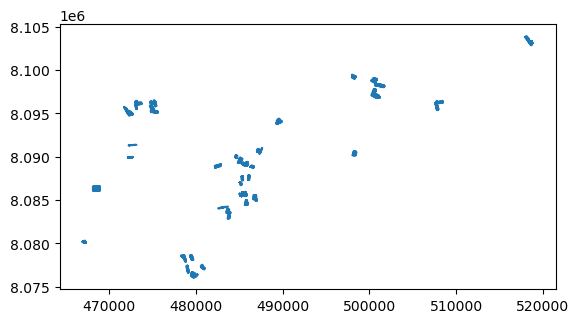

In [27]:
gdf_lineas.plot()

In [28]:
len(gdf_lineas)

57

In [29]:
gdf_lineas.to_file('capa_logs', driver="ESRI Shapefile")